In [153]:
import numpy as np
from SALib.sample import fast_sampler
from SALib.analyze import sobol
from SALib.analyze import fast
import matplotlib.pyplot as plt
from SALib import ProblemSpec
##########################
#http0.1://salib.readthedocs.io/en/latest/basics_with_interface.html
##########################
import sys
import os
sys.path.insert(0, os.path.abspath('../model'))
import Pacejka52 as pa52

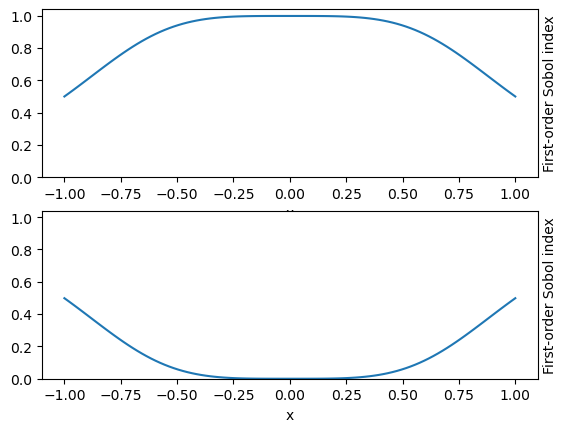

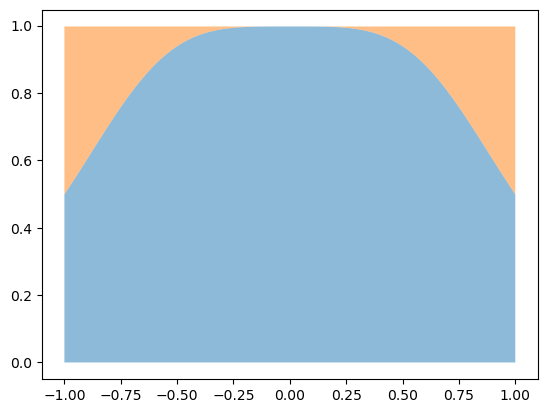

In [154]:
def parabola(x, a, b):
    """Return y = a + b*x**2."""
    return a + b*x**2


problem = {
    'num_vars': 2,
    'names': ['a', 'b'],
    'bounds': [[0, 1]]*2
}



X = fast_sampler.sample(problem, 100)

x1 = np.linspace(-1, 1, 100)
y1 = np.array([parabola(x1, *params) for params in X])

Si = [fast.analyze(problem, Y) for Y in y1.T]

S1s = np.array([s['S1'] for s in Si])

fig, ax = plt.subplots(2)

for i in range(0,2):
    ax[i].plot(x1, S1s[:, i])
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("First-order Sobol index")
    ax[i].set_ylim(0, 1.04)
    ax[i].yaxis.set_label_position("right")

plt.show()

s1_plt = np.array([x+y for x,y in zip(S1s[:, 0], S1s[:, 1])]) 
plt.figure(1)
plt.fill_between(x1, S1s[:, 0],0, alpha=0.5, label = 'a')
plt.fill_between(x1, S1s[:, 0], s1_plt,where = (s1_plt > S1s[:, 0]) , alpha=0.5, label = 'b')

26000


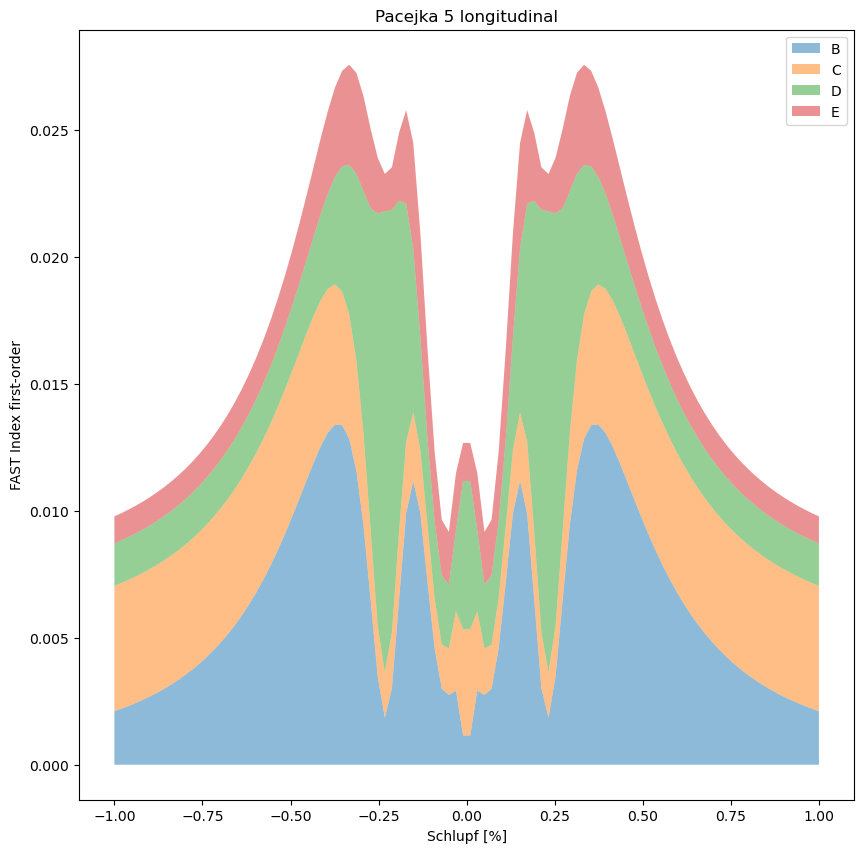

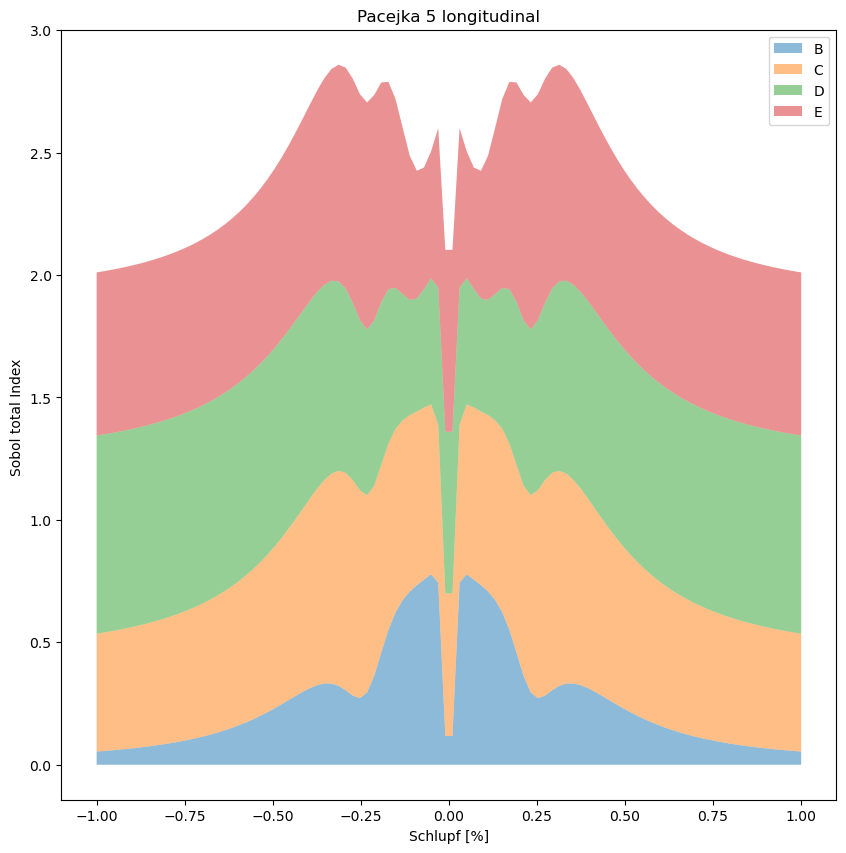

In [203]:
Fz = -4000
#function
def Pacejka5_long_fit(SL,B,C,D,E):

    Fx=-Fz* D * np.sin(C * np.arctan(D * SL - E * (B*SL - np.arctan(B * SL)))) 
    
    return Fx


problem = {
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[4,12], [1, 2], [0.1,1.9], [-10, 1]],
}
SL = np.linspace(-1,1,100)

def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = Pacejka5_long_fit(SL,B,C,D,E)

    return y

X = fast_sampler.sample(problem, 6500)

################################################################
#Filter
################################################################
import copy
a = copy.deepcopy(X)
print(len(a))
SL_filt = np.linspace(0,1,100)

def entferne_nullzeilen(matrix):
    return [zeile for zeile in matrix if any(zeile)]

params2 = [9.06434405,  1.60162373, 1.72069169, -0.80265574]
F_ref = Pacejka5_long_fit(SL_filt, *params2)
#Filter
for i in range(0,len(a)):
    params1 = a[i,:]
    F = Pacejka5_long_fit(SL_filt, *params1)
    
    #alle negativen Werte raus
    for j in range(0,len(F)):
        if F[j] < 0:
            a[i,:] = 0
            break
        else:
            continue
        
    #alle die eine zu flache Kurve haben
    
    #F_max = np.max(F)
    #F_max_ref = np.max(F_ref)
    #if F_max * 0.5 < F_max_ref < F_max * 1.5:
    #    continue
        # a[i,:] = 0
   # else:
   #    a[i,:] = 0
        
    laenge = int(len(F)/4)
    if F[laenge] < 6000: 
        a[i,:] = 0
             
    else:
        continue


a_neu = entferne_nullzeilen(a)

#check if its a multiply of D (=number of parameters)
def entferne_zeilen(matrix, anzahl_zeilen):
    return matrix[:-anzahl_zeilen]

if len(a_neu) % len(a_neu[0]) == 0:
    a_SA = a_neu
else:
    anzahl = len(a_neu) % len(a_neu[0])
    a_SA = entferne_zeilen(a_neu, anzahl)

################################################################

y1 = np.array([Pacejka5_long_fit(SL, *params) for params in a_SA])

Si = [fast.analyze(problem, Y) for Y in y1.T]

S1s = np.array([s['S1'] for s in Si])
STs = np.array([s['ST'] for s in Si])

S1s_B  = np.array(S1s[:,0])
S1s_C  = np.array(S1s[:,1])
S1s_D  = np.array(S1s[:,2])
S1s_E  = np.array(S1s[:,3])

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

plt.figure(2, figsize=(10,10))
plt.fill_between(SL,S1s_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(SL,S1s_B,S1s_C_plt, where = (S1s_C_plt > S1s_B), alpha=0.5, label = 'C')
plt.fill_between(SL,S1s_C_plt,S1s_D_plt, where = (S1s_D_plt > S1s_C_plt), alpha=0.5, label = 'D')
plt.fill_between(SL,S1s_D_plt,S1s_E_plt, where = (S1s_E_plt > S1s_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schlupf [%]')
plt.ylabel('FAST Index first-order')
plt.title('Pacejka 5 longitudinal')
plt.legend(loc='upper right')
plt.show()


STs_B  = np.array(STs[:,0])
STs_C  = np.array(STs[:,1])
STs_D  = np.array(STs[:,2])
STs_E  = np.array(STs[:,3])

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

plt.figure(3, figsize=(10,10))
plt.fill_between(SL,STs_B,0, alpha=0.5, label = 'B') #alpha = deckkraft farbe
plt.fill_between(SL,STs_B,STs_C_plt, where = (STs_C_plt > STs_B), alpha=0.5, label = 'C')
plt.fill_between(SL,STs_C_plt,STs_D_plt, where = (STs_D_plt > STs_C_plt), alpha=0.5, label = 'D')
plt.fill_between(SL,STs_D_plt,STs_E_plt, where = (STs_E_plt > STs_D_plt), alpha=0.5, label = 'E')
plt.xlabel('Schlupf [%]')
plt.ylabel('Sobol total Index ')
plt.title('Pacejka 5 longitudinal')
plt.legend(loc='upper right')
plt.show()


26000
2996


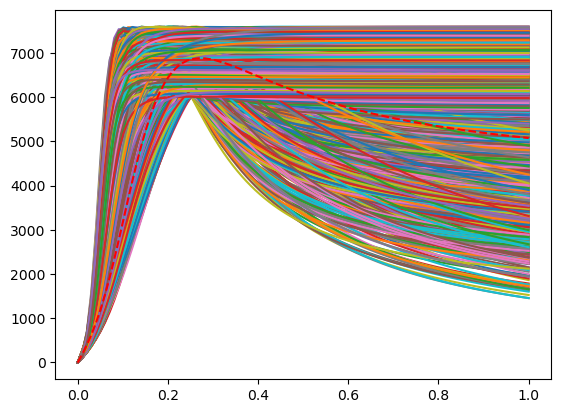

In [201]:
import copy
a = copy.deepcopy(X)
print(len(a))
SL = np.linspace(0,1,100)

def entferne_nullzeilen(matrix):
    return [zeile for zeile in matrix if any(zeile)]

params2 = [9.06434405,  1.60162373, 1.72069169, -0.80265574]
F_ref = Pacejka5_long_fit(SL, *params2)
#Filter
for i in range(0,len(a)):
    params1 = a[i,:]
    F = Pacejka5_long_fit(SL, *params1)
    
    #alle negativen Werte raus
    for j in range(0,len(F)):
        if F[j] < 0:
            a[i,:] = 0
            break
        else:
            continue
        
    #alle die eine zu flache Kurve haben
    
    #F_max = np.max(F)
    #F_max_ref = np.max(F_ref)
    #if F_max * 0.5 < F_max_ref < F_max * 1.5:
    #    continue
        # a[i,:] = 0
   # else:
   #    a[i,:] = 0
        
    laenge = int(len(F)/4)
    if F[laenge] < 6000: 
        a[i,:] = 0
             
    else:
        continue


a_neu = entferne_nullzeilen(a)

#check if its a multiply of D (=number of parameters)
def entferne_zeilen(matrix, anzahl_zeilen):
    return matrix[:-anzahl_zeilen]

if len(a_neu) % len(a_neu[0]) == 0:
    a_SA = a_neu
else:
    anzahl = len(a_neu) % len(a_neu[0])
    a_SA = entferne_zeilen(a_neu, anzahl)

print(len(a_SA))
for i in range(0,len(a_SA)):
    params_plot = a_SA[i]
    F_plot = Pacejka5_long_fit(SL, *params_plot)
    plt.plot(SL,F_plot)


plt.plot(SL,F_ref, 'r--')


In [200]:
len(a_neu[0])

4